In [1]:
import nltk
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../conf/clean.mplstyle')
%config InlineBackend.figure_format = 'retina'

## OpenAI

Either set OPENAI_API_KEY environment variable or pass `api_key` to `Client`.

In [3]:
from openai import OpenAI
client = OpenAI()

In [4]:
def openai_embed(text):
    res = client.embeddings.create(input=text, model='text-embedding-3-large')
    return np.array([d.embedding for d in res.data]).squeeze()

(3072,)


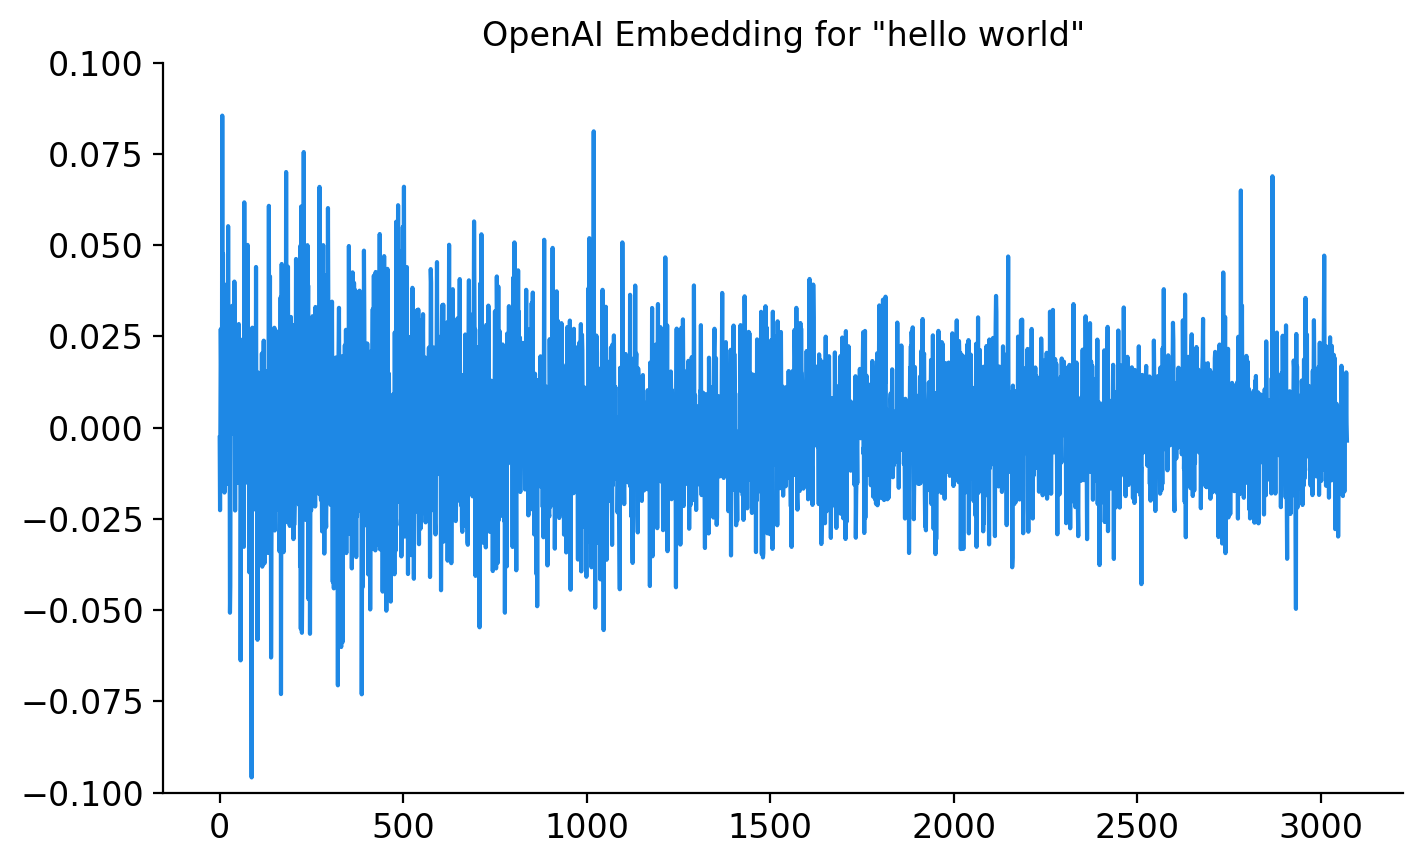

In [5]:
vec = openai_embed('hello world')
print(vec.shape)
fig, ax = plt.subplots()
pd.Series(vec).plot(title='OpenAI Embedding for "hello world"', ylim=(-0.1, 0.1), ax=ax);
fig.savefig('../docs/images/hello_world_embed.png', bbox_inches='tight', dpi=200);

## llama.cpp

Get the GGUF format model from Compendium's Huggingface repo: https://huggingface.co/CompendiumLabs/bge-large-en-v1.5-gguf. Then put it in the `models` directory.

In [6]:
import llama_cpp
model_path = '/home/doug/mlai/llama.cpp/fast_embed/nomic-embed-text-v1.5-f16.gguf'
model = llama_cpp.Llama(model_path, embedding=True, verbose=False)

In [7]:
def llama_embed(text):
    return np.array(model.embed(text, normalize=True))

(768,)


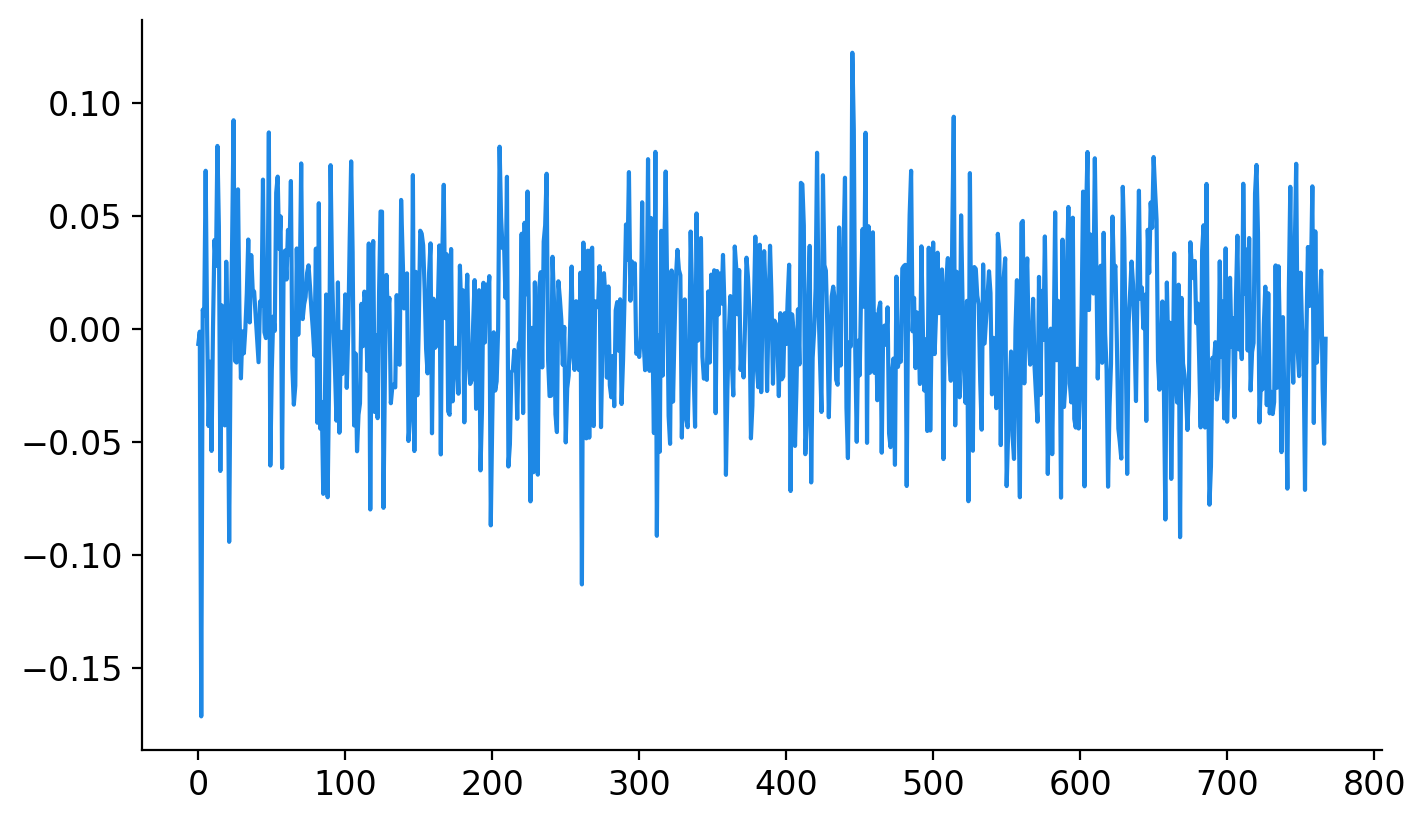

In [8]:
vec1 = llama_embed('hello world')
print(vec1.shape)
pd.Series(vec1).plot();

## Inaugurals

In [9]:
nltk.download('inaugural')

[nltk_data] Downloading package inaugural to
[nltk_data]     /media/genesis/data/nltk...
[nltk_data]   Package inaugural is already up-to-date!


True

In [10]:
pres = nltk.corpus.inaugural.fileids()
inaug_text = [nltk.corpus.inaugural.open(f).read() for f in pres]
inaug_year = np.array([int(s.split('-')[0]) for s in pres])

In [11]:
print(inaug_text[0][:1889])

Fellow-Citizens of the Senate and of the House of Representatives:

Among the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the 14th day of the present month. On the one hand, I was summoned by my Country, whose voice I can never hear but with veneration and love, from a retreat which I had chosen with the fondest predilection, and, in my flattering hopes, with an immutable decision, as the asylum of my declining years -- a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination, and of frequent interruptions in my health to the gradual waste committed on it by time. On the other hand, the magnitude and difficulty of the trust to which the voice of my country called me, being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his qualifications, could not bu

In [12]:
inaug_embed = openai_embed([text[:8192] for text in inaug_text])

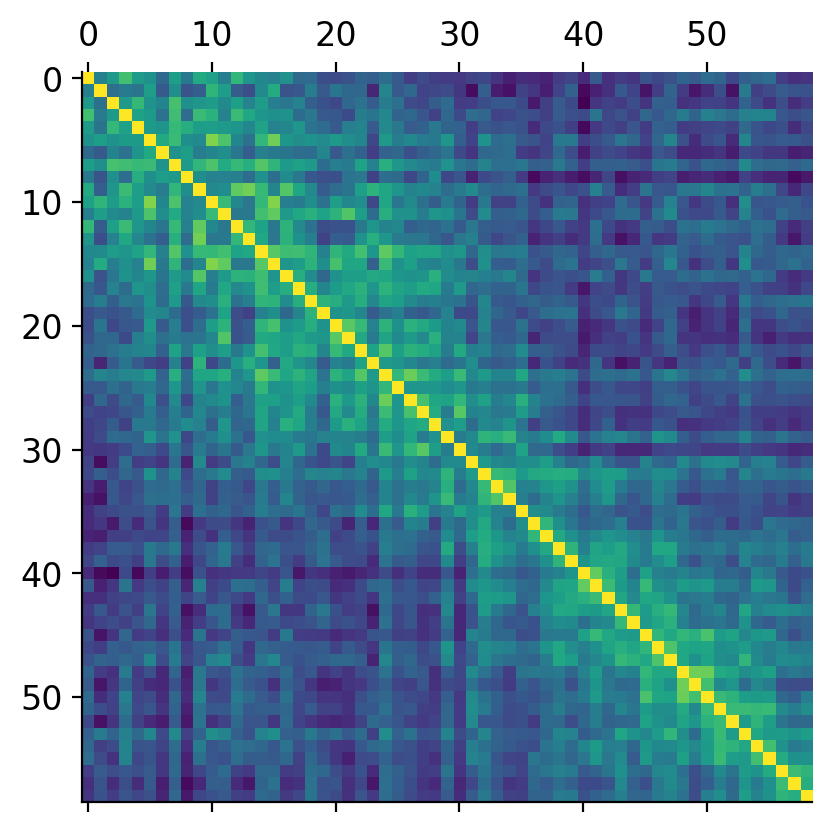

In [13]:
inaug_simil = (inaug_embed @ inaug_embed.T)
fig, ax = plt.subplots()
ax.matshow(inaug_simil);

2024-05-02 14:30:20.952999: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 14:30:20.954279: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 14:30:20.972789: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 14:30:20.973473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 14:30:21.414721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

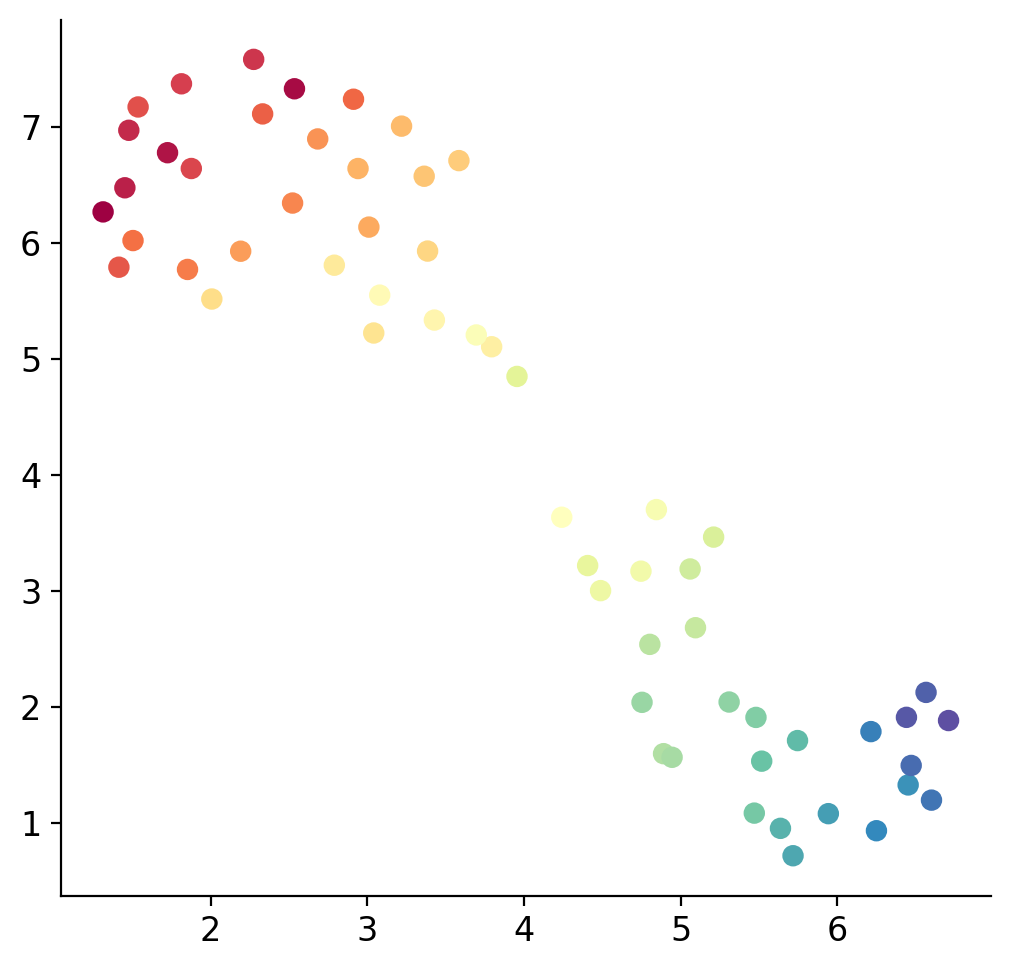

In [14]:
import umap
udat_inaug = umap.UMAP().fit(inaug_embed)
edat = udat_inaug.embedding_
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(*edat.T, c=inaug_year, cmap='Spectral', s=45)

### Sentiment

In [15]:
fear = openai_embed('fear')
fear_sim = fear @ inaug_embed.T

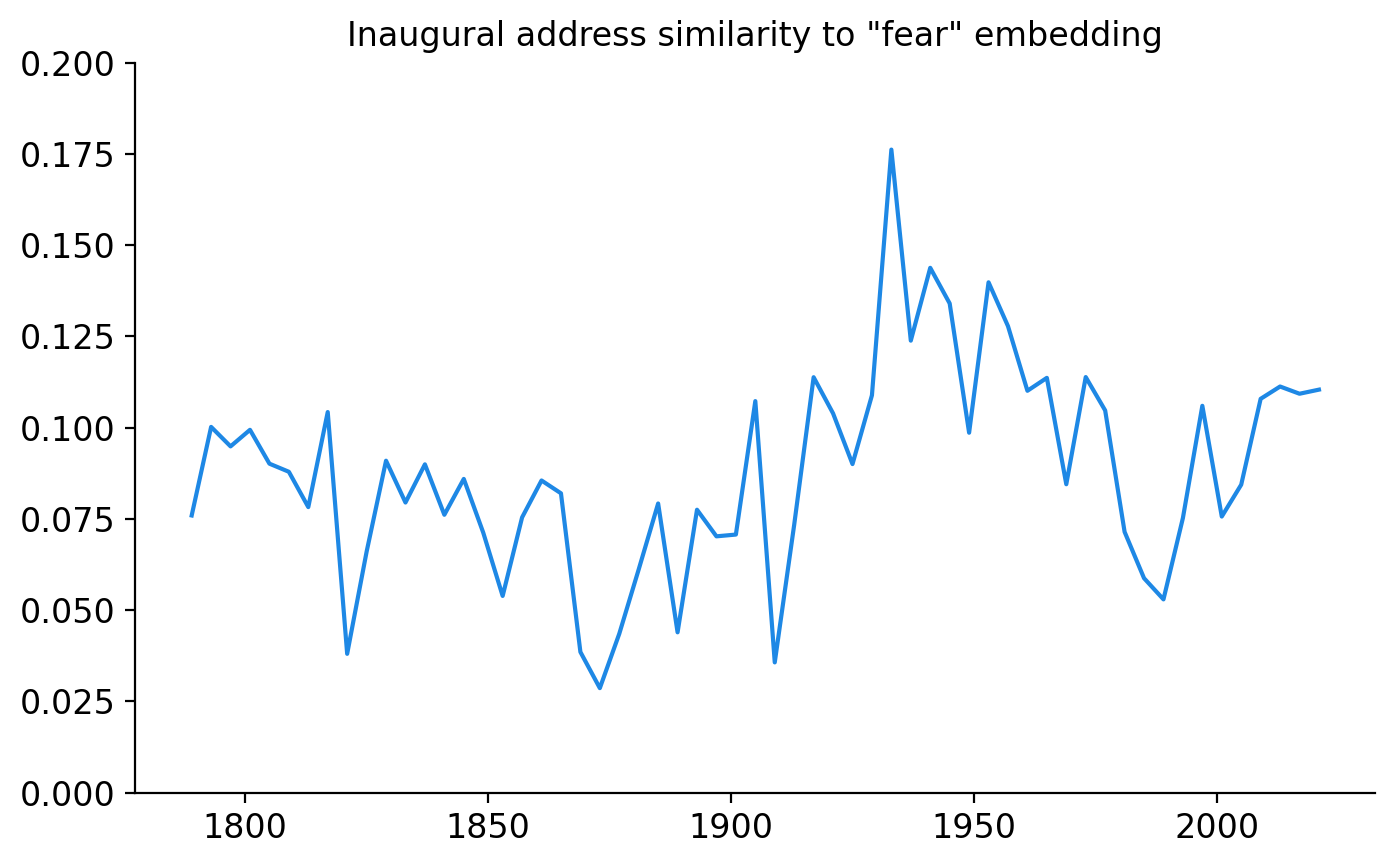

In [16]:
fig, ax = plt.subplots()
s_fear = pd.Series(fear_sim, index=inaug_year)
s_fear.plot(title='Inaugural address similarity to "fear" embedding', ylim=(0, 0.2), ax=ax);
fig.savefig('../docs/images/fear_series.png', bbox_inches='tight', dpi=200);